In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

from zilean import SnapShots

import pickle, os, json

# GLOBAL VARIABLES
FRAMES = [15, 8]
PER_FRAME = False

MODEL_ID = ("frame_" if PER_FRAME else "match_") + "_".join(str(e) for e in FRAMES)

# FILENAME
CSV_FILE_NAME = "data/" + MODEL_ID + ".csv"
SOURCE_FILE_NAME = "data/matches.json"
RESULT_FILE_NAME = "models/results.json"

In [2]:
def plot_roc_curve(y, prob):
    fpr, tpr, _ = roc_curve(y, prob)
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='example estimator')
    display.plot()

def print_metrics(model, X_train, X_test, y_train, y_test):
    y_fit = model.predict(X_train)
    y_predict = model.predict(X_test)
    print(f"Train Accuracy: {np.mean(y_train == y_fit)}. Test Accuracy {np.mean(y_test == y_predict)}.")
    plot_roc_curve(y_test, model.predict_proba(X_test)[:,1])

In [3]:
if os.path.exists(CSV_FILE_NAME):
    snaps = SnapShots(CSV_FILE_NAME, frames=FRAMES)
    data = pd.DataFrame(snaps.summary(per_frame=PER_FRAME))
    print("Succesfully loaded cached data csv.")
else:
    snaps = SnapShots(SOURCE_FILE_NAME, frames=FRAMES)
    data = pd.DataFrame(snaps.summary(per_frame=PER_FRAME))
    snaps.to_disk()

scaler = StandardScaler()

X = data.drop(["win", "matchId"], axis=1)
y = data['win'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the scaler and transform X
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Record column names
X_col_names = list(X.columns)

Saved files to direcotry data/.


## Random Forest Classifier

In [4]:
from sklearn.ensemble import RandomForestClassifier

In [5]:
RETRAIN = False
rf_file = "models/rf_cv.pkl"

if os.path.exists(rf_file) and not RETRAIN:
    with open(rf_file, "rb") as f:
        grid = pickle.load(f)
    print("Succesfully loaded cached gridCV result.")
else:
    rf = RandomForestClassifier(random_state=42)
    param_grid = {"n_estimators": (10 ** np.linspace(0, 2.7, 100)).astype(int),
                "max_depth": [6, 8, 10]}
    grid = GridSearchCV(rf, param_grid, scoring="accuracy", n_jobs=-1, verbose=3, cv=10)
    grid.fit(X_train, y_train)

    with open(rf_file, "wb") as f:
        pickle.dump(grid, f)

Succesfully loaded cached gridCV result.


Train Accuracy: 0.9133574007220217. Test Accuracy 0.8365384615384616.


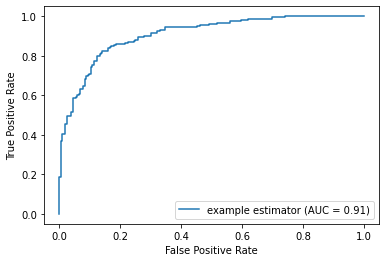

In [6]:
rf_cv_result = pd.DataFrame(grid.cv_results_)
final_rf = grid.best_estimator_
final_rf.fit(X_train, y_train)

#sns.lineplot(x="param_n_estimators", y="mean_test_score", hue="param_max_depth", data=rf_cv_result)
print_metrics(final_rf, X_train, X_test, y_train, y_test)

## XGBoost Classifier

In [7]:
from xgboost import XGBClassifier

In [8]:
RETRAIN = False
xgb_file = "models/xgb_cv.pkl"

if os.path.exists(xgb_file) and not RETRAIN:
    with open(xgb_file, "rb") as f:
        grid = pickle.load(f)
    print("Succesfully loaded cached gridCV result.")

else:
    xgb = XGBClassifier(eval_metric="logloss", use_label_encoder=False, verbosity=0, silent=True, random_state=42)
    param_grid = {"n_estimators": (10**np.linspace(1.3, 2.2, 10)).astype(int),
                  "subsample": [0.4, 0.5, 0.6, 0.7, 0.8],
                  "colsample_bytree": [0.2, 0.4, 0.6, 0.8],
                  "colsample_bylevel": [0.2, 0.4, 0.6, 0.8],
                  "max_depth": [2, 4, 6]}
    grid = GridSearchCV(xgb, param_grid, scoring="accuracy", cv=5, n_jobs=5)
    grid.fit(X_train, y_train)

    with open(xgb_file, "wb") as f:
            pickle.dump(grid, f)

Succesfully loaded cached gridCV result.


Train Accuracy: 0.8333333333333334. Test Accuracy 0.7980769230769231.


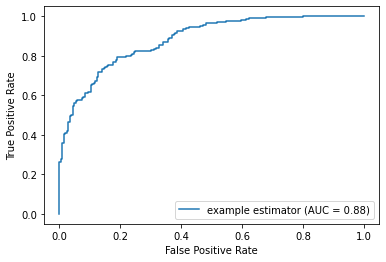

In [9]:
xgb_cv_result = pd.DataFrame(grid.cv_results_)
final_xgb = grid.best_estimator_
final_xgb.fit(X_train, y_train)

print_metrics(final_xgb, X_train, X_test, y_train, y_test)

## Write Results

In [10]:
if os.path.exists(RESULT_FILE_NAME):
    with open(RESULT_FILE_NAME, "r") as f:
        results = json.load(f)
    print("Successfully loaded cached results.")
else:
    results = []

for result in results:
    if result["id"] == MODEL_ID:
        results.remove(result)

result = {}
# Metadata
result["id"] = MODEL_ID
result["frames"] = "_".join(str(e) for e in FRAMES)
result["type"] = ("frame" if PER_FRAME else "match")
# For metrics (accuracy, AUC, etc.)
result["y_test"] = list(y_test)
result["y_proba_rf"] = list(final_rf.predict_proba(X_test)[:,1].astype(float))
result["y_proba_xgb"] = list(final_xgb.predict_proba(X_test)[:,1].astype(float))
# For feature importances
result["features"] = list(X_col_names)
result["importances_rf"] = list(final_rf.feature_importances_.astype(float))
result["importances_xgb"] = list(final_xgb.feature_importances_.astype(float))

results += [result]

with open(RESULT_FILE_NAME, "w") as f:
    json.dump(results, f)
print(f"Successfully wrote to results at {RESULT_FILE_NAME}")

Successfully loaded cached results.
Successfully wrote to results at models/results.json
